# Task 3 Predictive Anlysis

## Import the libraries

In [4]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import sklearn.decomposition
from collections import defaultdict
from scipy.stats import pearsonr
import seaborn as sn
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, make_scorer, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report
import pydotplus 
from IPython.display import Image  

from sklearn.ensemble import RandomForestClassifier

In [5]:
!pip3 install scikit-plot

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [6]:
from scikitplot.metrics import plot_roc

## Data Preparation before Classifcation

We only use a subset of the features for the classification, we remove those that we deem less relevant for the classification and the attributes too related to the feature used to create the labels.

In [7]:
Profile=pd.read_csv('../Dataset/UserProfile.csv', skipinitialspace=True, sep=',',index_col=0)

In [8]:
Profile.drop(columns=['user_id','minAmount_BSKT','Iu','entropy_CategoryID'], inplace=True)

In [9]:
Profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824 entries, 0 to 823
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Imax                824 non-null    float64
 1   I                   824 non-null    float64
 2   IAvg                824 non-null    float64
 3   meanAmount_BSKT     824 non-null    float64
 4   maxAmount_BSKT      824 non-null    float64
 5   unique_baskets      824 non-null    float64
 6   totalAmount         824 non-null    float64
 7   entropy_itemID      824 non-null    float64
 8   avg_month_spent     824 non-null    float64
 9   stdAmount_BSKT      824 non-null    float64
 10  stdMean_ratio       824 non-null    float64
 11  totalAmount_factor  824 non-null    float64
dtypes: float64(12)
memory usage: 83.7 KB


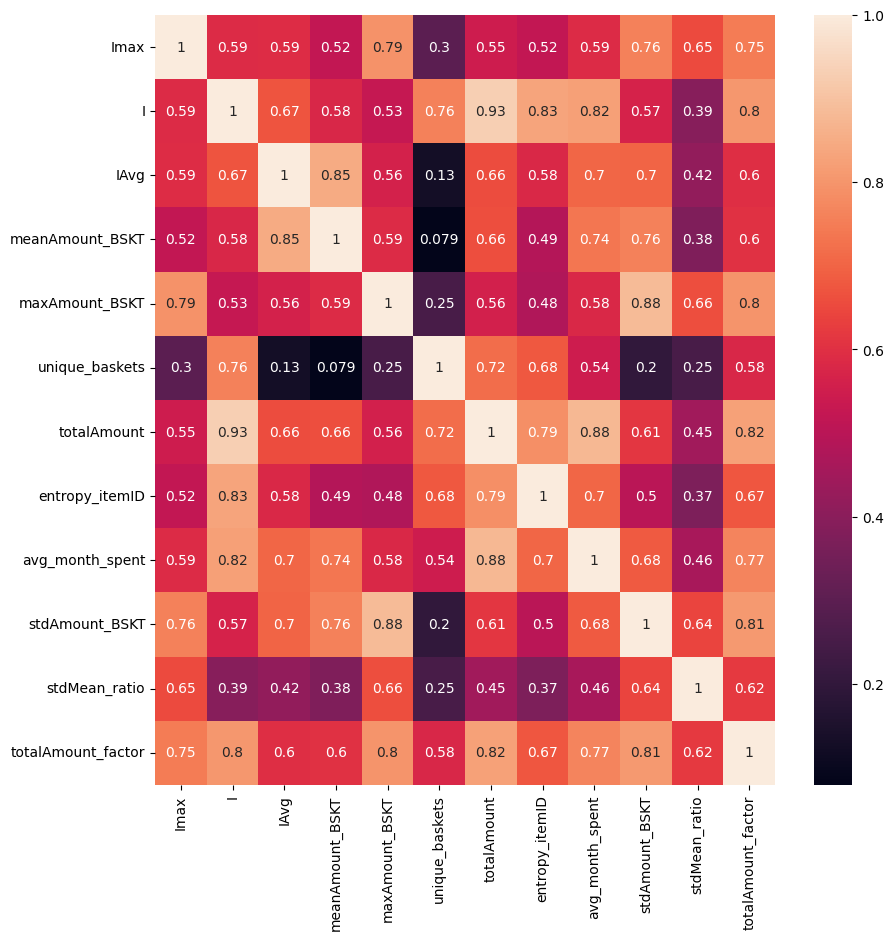

In [10]:
corr_matrix = Profile.corr()
plt.figure(figsize=(10,10))
sn.heatmap(abs(corr_matrix), annot=True)
plt.show()

In [11]:
Uncorr = Profile[['meanAmount_BSKT','unique_baskets','stdMean_ratio','totalAmount','totalAmount_factor','stdAmount_BSKT','maxAmount_BSKT']]

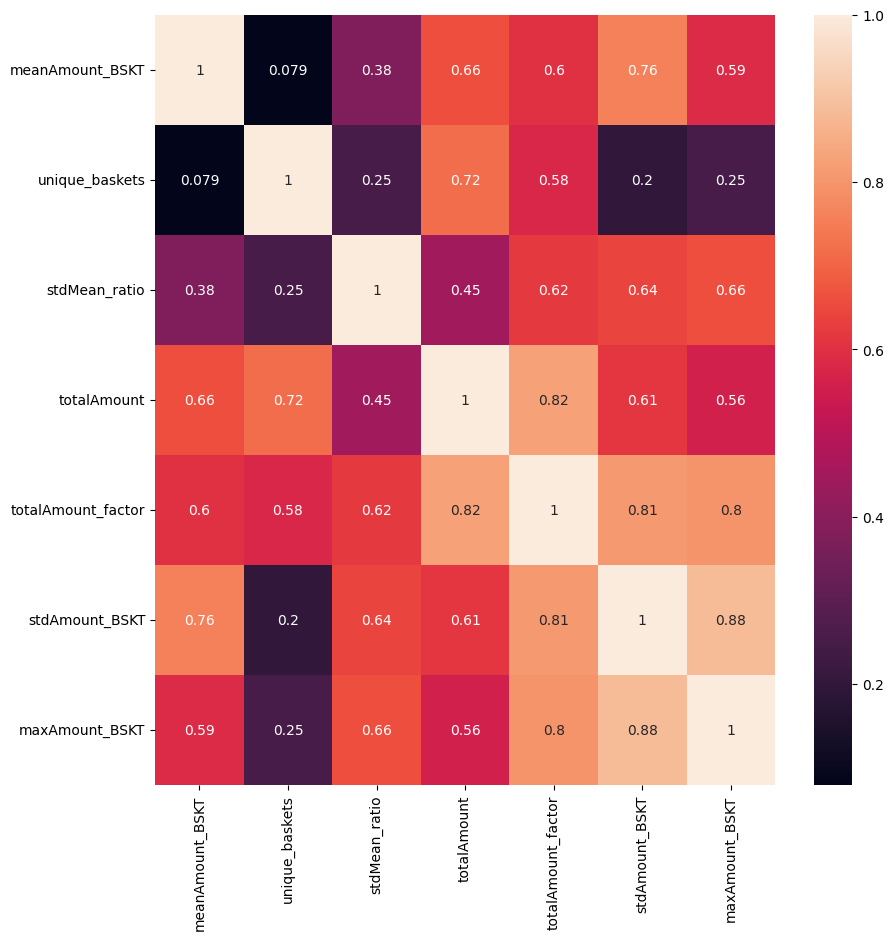

In [12]:
corr_matrix = Uncorr.corr()
plt.figure(figsize=(10,10))
sn.heatmap(abs(corr_matrix), annot=True)
plt.show()

## Create label
Before the classification we should create the label, 
to create the label we use the meanAmount_BSKT attribute which describes the user's behavior during a shopping session, we distribute customers among the various labels using quantiles.

In [13]:
Q1 = Uncorr['meanAmount_BSKT'].quantile(0.25)
Q3 = Uncorr['meanAmount_BSKT'].quantile(0.75)

labels = []
for customer, Savg in Uncorr.meanAmount_BSKT.items():
    if Savg < Q1:
        labels.append(0)
    elif Savg > Q3:
        labels.append(2)
    else:
        labels.append(1)


In [14]:
Uncorr.drop(columns=['meanAmount_BSKT'], inplace=True)
class_names = ['low-spending', 'medium-spending', 'high-spending']

/var/folders/nx/7fwc9svx06d5smgh8xw0ql4m0000gn/T/ipykernel_65911/3537833490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Uncorr.drop(columns=['meanAmount_BSKT'], inplace=True)


In [15]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts()

1    412
2    206
0    206
Name: labels, dtype: int64

In [16]:
Profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824 entries, 0 to 823
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Imax                824 non-null    float64
 1   I                   824 non-null    float64
 2   IAvg                824 non-null    float64
 3   meanAmount_BSKT     824 non-null    float64
 4   maxAmount_BSKT      824 non-null    float64
 5   unique_baskets      824 non-null    float64
 6   totalAmount         824 non-null    float64
 7   entropy_itemID      824 non-null    float64
 8   avg_month_spent     824 non-null    float64
 9   stdAmount_BSKT      824 non-null    float64
 10  stdMean_ratio       824 non-null    float64
 11  totalAmount_factor  824 non-null    float64
dtypes: float64(12)
memory usage: 83.7 KB


In [17]:
Profile = Uncorr

# Classification

We make the classification using various models: Random-Forest, Decision Tree, Knn, SVM, Naive Bayes for each of them we return the various results and measures for both the test set and the training set and we show the confusion matrix and the roc curve.

We use function reoport for print the measure of classification

In [18]:

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['low-spending', 'medium-spending', 'high-spending']))

In [19]:

def plot_feature_hist(classifier, features):
  plt.bar(features, classifier.feature_importances_)
  plt.xticks(rotation='vertical')
  plt.tight_layout()
  plt.show()

## Decision Tree

In [20]:

train_set, test_set, train_label, test_label = train_test_split(Profile, labels, stratify =labels, test_size=0.30)

In [21]:

dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

In [24]:

dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low-spending', 'medium-spending', 'high-spending'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [ ]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [ ]:
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9600694444444444
Accuracy test set  0.842741935483871
Precision train set  0.9608177860067316
Recall train set  0.9600694444444444
F1 score train set  0.9600185456883058
Support train set  (array([0.93421053, 0.96193772, 0.98518519]), array([0.98611111, 0.96527778, 0.92361111]), array([0.95945946, 0.96360485, 0.95340502]), array([144, 288, 144]))


In [ ]:
report_scores(test_label, test_pred_dt)

                 precision    recall  f1-score   support

   low-spending       0.84      0.95      0.89        62
medium-spending       0.84      0.87      0.86       124
  high-spending       0.88      0.71      0.79        62

       accuracy                           0.85       248
      macro avg       0.86      0.84      0.85       248
   weighted avg       0.85      0.85      0.85       248



In [ ]:
report_scores(train_label, train_pred_dt)

                 precision    recall  f1-score   support

   low-spending       0.93      0.99      0.96       144
medium-spending       0.96      0.97      0.96       288
  high-spending       0.99      0.92      0.95       144

       accuracy                           0.96       576
      macro avg       0.96      0.96      0.96       576
   weighted avg       0.96      0.96      0.96       576



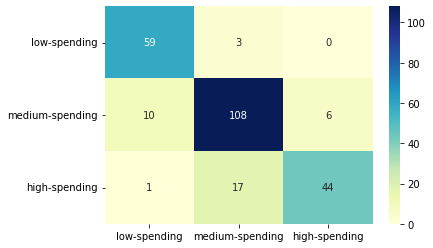

In [ ]:
confusion = pd.DataFrame(confusion_matrix(test_label, test_pred_dt), 
                         columns=['low-spending', 'medium-spending', 'high-spending'], index=['low-spending', 'medium-spending', 'high-spending'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

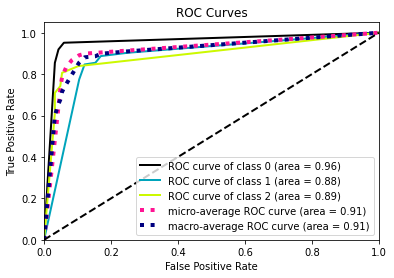

In [ ]:
plot_roc(test_label, dt.predict_proba(test_set))
plt.show()

We also show the importance that features had in the classification.

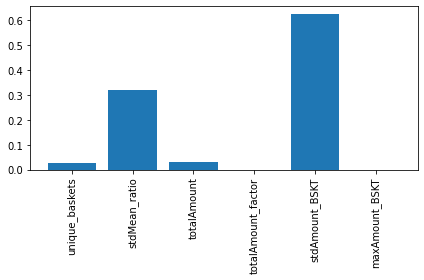

In [ ]:
plot_feature_hist(dt, train_set.columns.values)

## Random Forest

We use a function that returns the best parameters to use for classification with the random forest.

In [ ]:
# define the parameter ranges we want to try, then run the grid search

num_estimators = 30
param_dist = {"max_depth": [3,5,6,7,8,9,10,11,12,None],
              "max_features": sp_randint(1, 7),
              "min_samples_split": sp_randint(3, 20),
              "min_samples_leaf": sp_randint(5, 20),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
n_iter_search = 50
clf = RandomForestClassifier(n_estimators=num_estimators)
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcbef9ac0a0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcbf59feb20>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcbedf65340>},
                   scoring=make_scorer(accuracy_score))

In [ ]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 9, 'min_samples_split': 9}
Mean and std of this setting  0.7829835082458771 0.030629725519005387


In [ ]:
#define and fit a random forest

rf = RandomForestClassifier(n_estimators=30, 
                             criterion='entropy',
                             max_features=5,
                             max_depth=10, 
                             min_samples_split=4,
                             min_samples_leaf=5,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

In [ ]:
test_pred_rf = rf.predict(test_set)
train_pred_rf = rf.predict(train_set)

In [ ]:

report_scores(test_label, test_pred_rf)

                 precision    recall  f1-score   support

   low-spending       0.93      0.89      0.91        62
medium-spending       0.84      0.93      0.88       124
  high-spending       0.90      0.76      0.82        62

       accuracy                           0.88       248
      macro avg       0.89      0.86      0.87       248
   weighted avg       0.88      0.88      0.87       248



In [ ]:
report_scores(train_label, train_pred_rf)

                 precision    recall  f1-score   support

   low-spending       0.99      0.94      0.97       144
medium-spending       0.95      0.99      0.97       288
  high-spending       0.98      0.95      0.96       144

       accuracy                           0.97       576
      macro avg       0.97      0.96      0.97       576
   weighted avg       0.97      0.97      0.97       576



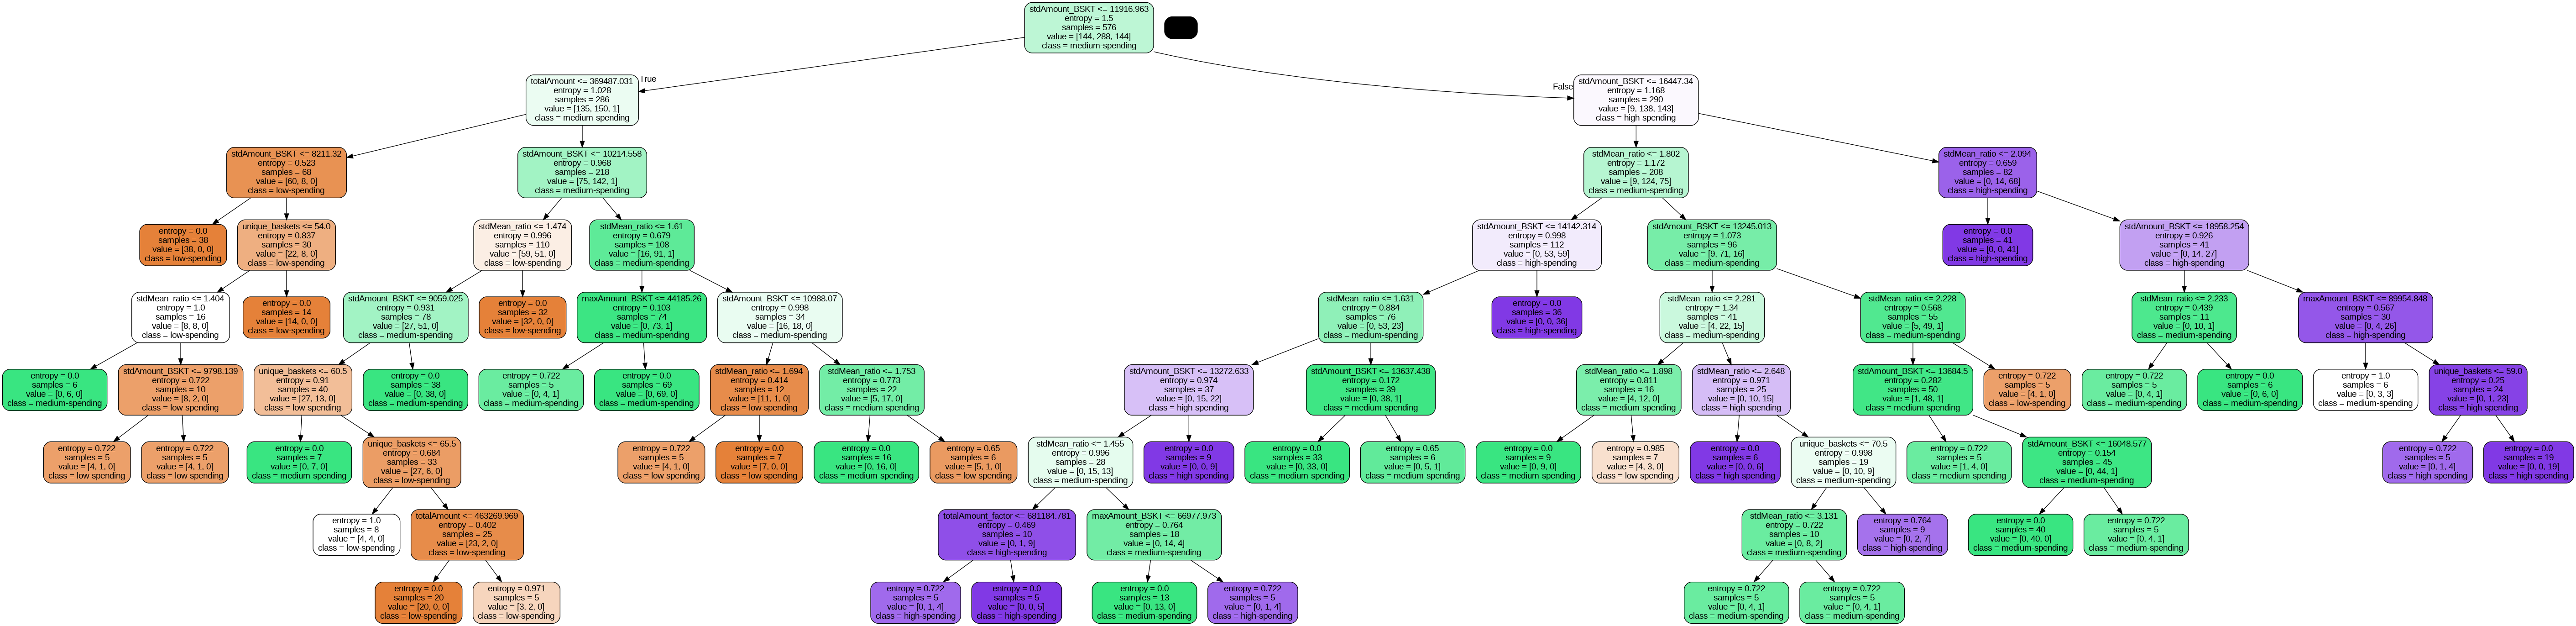

In [ ]:
#plotto solo una parte del grafico
dot_data = tree.export_graphviz(rf[0], out_file=None,
                         feature_names=list(train_set.columns),
                         class_names=['low-spending', 'medium-spending', 'high-spending'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

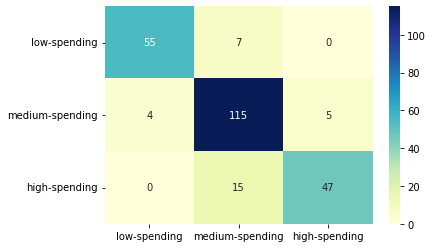

In [ ]:
confusion = pd.DataFrame(confusion_matrix(test_label, test_pred_rf), 
                         columns=['low-spending', 'medium-spending', 'high-spending'], index=['low-spending', 'medium-spending', 'high-spending'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

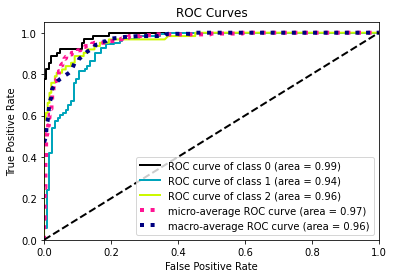

In [ ]:
plot_roc(test_label, rf.predict_proba(test_set))
plt.show()

We also show the importance that features had in the classification.

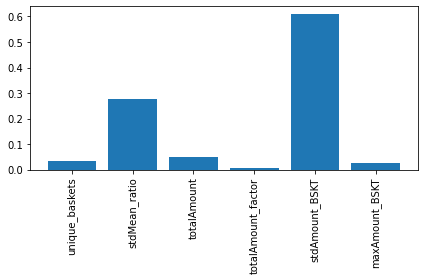

In [ ]:
plot_feature_hist(rf, train_set.columns.values)

## Naive Bayses

In [ ]:
# define and fit naive bayes model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set, train_label)

test_pred_gnb = gnb.predict(test_set)
train_pred_gnb=gnb.predict(train_set)

report_scores(test_label,test_pred_gnb)

                 precision    recall  f1-score   support

   low-spending       0.56      0.81      0.66        62
medium-spending       0.69      0.47      0.56       124
  high-spending       0.61      0.74      0.67        62

       accuracy                           0.62       248
      macro avg       0.62      0.67      0.63       248
   weighted avg       0.64      0.62      0.61       248



In [ ]:
report_scores(train_label, train_pred_gnb)

                 precision    recall  f1-score   support

   low-spending       0.60      0.77      0.67       144
medium-spending       0.69      0.56      0.62       288
  high-spending       0.63      0.68      0.66       144

       accuracy                           0.64       576
      macro avg       0.64      0.67      0.65       576
   weighted avg       0.65      0.64      0.64       576



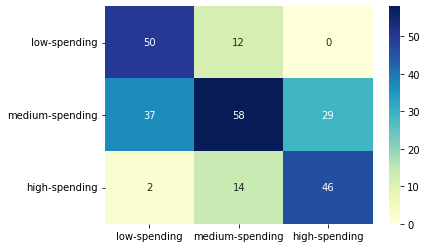

In [ ]:
confusion = pd.DataFrame(confusion_matrix(test_label, test_pred_gnb), 
                         columns=['low-spending', 'medium-spending', 'high-spending'], index=['low-spending', 'medium-spending', 'high-spending'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

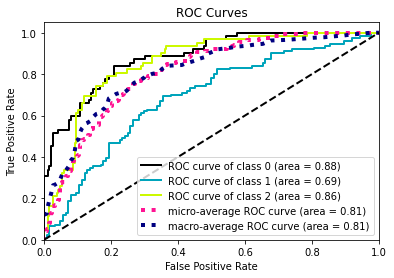

In [ ]:
plot_roc(test_label, gnb.predict_proba(test_set))
plt.show()

## SVM

In [ ]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set, train_label)

test_pred_svm = svm.predict(test_set)
train_pred_svm=svm.predict(train_set)
report_scores(test_label, test_pred_svm)

                 precision    recall  f1-score   support

   low-spending       0.05      0.10      0.07        62
medium-spending       0.61      0.18      0.27       124
  high-spending       0.03      0.05      0.04        62

       accuracy                           0.12       248
      macro avg       0.23      0.11      0.13       248
   weighted avg       0.33      0.12      0.16       248



In [ ]:
report_scores(train_label, train_pred_svm)

                 precision    recall  f1-score   support

   low-spending       0.06      0.10      0.08       144
medium-spending       0.68      0.29      0.40       288
  high-spending       0.02      0.03      0.03       144

       accuracy                           0.18       576
      macro avg       0.26      0.14      0.17       576
   weighted avg       0.36      0.18      0.23       576



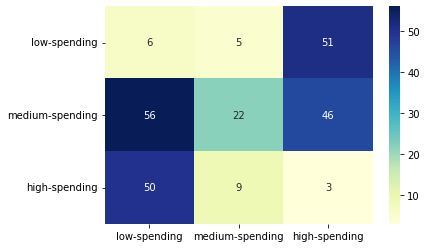

In [ ]:
confusion = pd.DataFrame(confusion_matrix(test_label, test_pred_svm), 
                         columns=['low-spending', 'medium-spending', 'high-spending'], index=['low-spending', 'medium-spending', 'high-spending'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

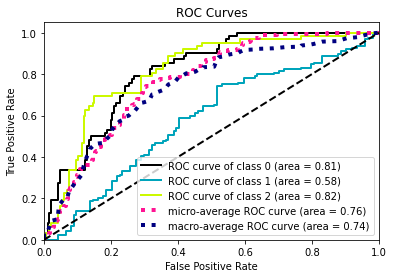

In [ ]:
plot_roc(test_label, svm.predict_proba(test_set))
plt.show()

## KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [ ]:
test_pred_knn = knn.predict(test_set)
train_pred_knn = knn.predict(train_set)

In [ ]:
report_scores(test_label,test_pred_knn)

                 precision    recall  f1-score   support

   low-spending       0.54      0.55      0.54        62
medium-spending       0.60      0.71      0.65       124
  high-spending       0.76      0.47      0.58        62

       accuracy                           0.61       248
      macro avg       0.63      0.58      0.59       248
   weighted avg       0.63      0.61      0.61       248



In [ ]:
report_scores(train_label, train_pred_knn)

                 precision    recall  f1-score   support

   low-spending       0.73      0.62      0.67       144
medium-spending       0.63      0.76      0.69       288
  high-spending       0.64      0.48      0.55       144

       accuracy                           0.65       576
      macro avg       0.67      0.62      0.63       576
   weighted avg       0.66      0.65      0.65       576



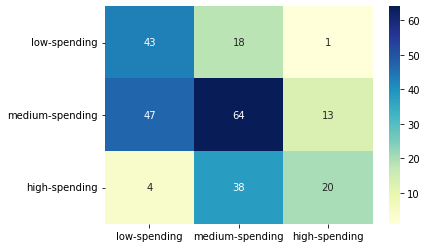

In [ ]:
confusion = pd.DataFrame(confusion_matrix(test_label, test_pred_knn), 
                         columns=['low-spending', 'medium-spending', 'high-spending'], index=['low-spending', 'medium-spending', 'high-spending'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

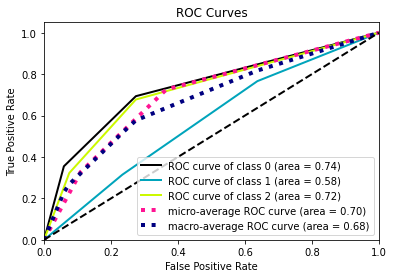

In [ ]:
plot_roc(test_label, knn.predict_proba(test_set))
plt.show()

## AdaBoost

In [ ]:
ada = AdaBoostClassifier()
ada.fit(train_set, train_label)
test_pred_clf = ada.predict(test_set)
train_pred_clf = ada.predict(train_set)
report_scores(test_label,test_pred_clf)

                 precision    recall  f1-score   support

   low-spending       1.00      0.10      0.18        62
medium-spending       0.54      0.95      0.69       124
  high-spending       0.75      0.29      0.42        62

       accuracy                           0.57       248
      macro avg       0.76      0.45      0.43       248
   weighted avg       0.71      0.57      0.49       248



In [ ]:
report_scores(train_label,train_pred_clf)

                 precision    recall  f1-score   support

   low-spending       1.00      0.13      0.23       144
medium-spending       0.56      0.94      0.70       288
  high-spending       0.76      0.35      0.48       144

       accuracy                           0.59       576
      macro avg       0.77      0.48      0.47       576
   weighted avg       0.72      0.59      0.53       576



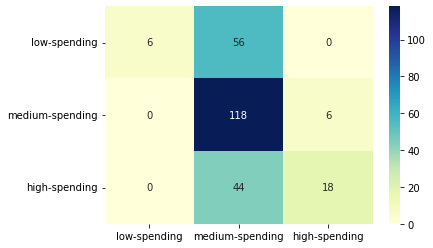

In [ ]:
confusion = pd.DataFrame(confusion_matrix(test_label, test_pred_clf), 
                         columns=['low-spending', 'medium-spending', 'high-spending'], index=['low-spending', 'medium-spending', 'high-spending'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

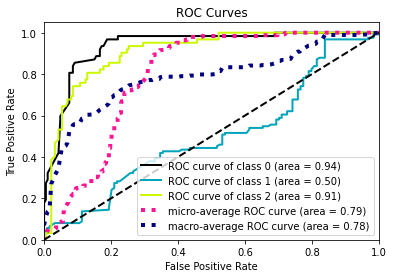

In [ ]:
plot_roc(test_label, ada.predict_proba(test_set))
plt.show()

We also show the importance that features had in the classification.

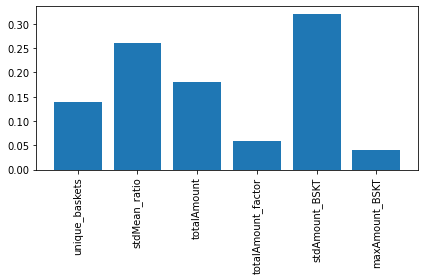

In [ ]:
plot_feature_hist(ada, train_set.columns.values)